In [1]:
# https://towardsdatascience.com/retain-customers-with-time-to-event-modeling-driven-intervention-de517a39c6e3
# https://github.com/awslabs/aws-customer-churn-pipeline/blob/main/notebook/coxph/Example_Churn_Surv.ipynb
# tracking risk over time to determine when a marketing intervention is needed to retain a customer

Note: this is really done well - really enjoyed working through author's work
Look through the original

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import xgboost as xgb
import shap
import sksurv.metrics as surv_metrics
from sksurv.datasets import get_x_y
from lifelines import KaplanMeierFitter
from lifelines.plotting import plot_lifetimes
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import DataConversionWarning
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


plt.rcParams['figure.figsize'] = [7.2, 4.8]
pd.set_option("display.float_format", lambda x: "%.4f" % x)

sns.set_style('darkgrid')

SEED = 123


C:\Users\nikig\anaconda3\envs\AutoML\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [7]:
#!conda install -c sebp scikit-survival


^C


In [3]:
import pandas as pd
data_path = 'https://raw.githubusercontent.com/awslabs/aws-customer-churn-pipeline/main/data/churn.txt'

churn_df = pd.read_csv(data_path)

In [4]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           5000 non-null   object 
 1   Account Length  5000 non-null   int64  
 2   Area Code       5000 non-null   int64  
 3   Phone           5000 non-null   object 
 4   Int'l Plan      5000 non-null   object 
 5   VMail Plan      5000 non-null   object 
 6   VMail Message   5000 non-null   int64  
 7   Day Mins        5000 non-null   float64
 8   Day Calls       5000 non-null   int64  
 9   Day Charge      5000 non-null   float64
 10  Eve Mins        5000 non-null   float64
 11  Eve Calls       5000 non-null   int64  
 12  Eve Charge      5000 non-null   float64
 13  Night Mins      5000 non-null   float64
 14  Night Calls     5000 non-null   int64  
 15  Night Charge    5000 non-null   float64
 16  Intl Mins       5000 non-null   float64
 17  Intl Calls      5000 non-null   i

In [10]:
churn_df.sample(2)

,state,duration,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,event
2063,UT,78,858,no,no,0,5.7886,2,4.2870,4.8640,0,5.4917,3.8308,150,6.9169,4.0587,3,2.7973,8,1
3364,WY,136,878,yes,no,0,4.1459,1,1.8161,2.2394,2,5.9648,6.5032,200,4.4391,4.2942,6,3.1616,8,0


In [6]:
# clean up the column names
churn_df.columns = [s.lower().replace(" ","_").replace("'","") for s in churn_df.columns.tolist()]

# remove id and set area code as categorical
del churn_df['phone']
churn_df['area_code'] = churn_df['area_code'].astype('category')

# denoting churn and duration
churn_df["event"] = np.where(churn_df["churn?"] == "False.", 0, 1)
churn_df = churn_df.rename(columns={"account_length": "duration"})

del churn_df['churn?']

churn_df = churn_df.dropna()
churn_df = churn_df.drop_duplicates()


<AxesSubplot:>

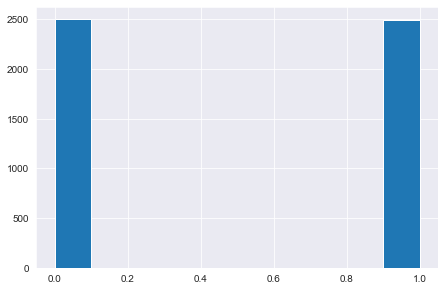

In [7]:
churn_df.event.hist() # target balanced

In [8]:
print("Total Records:",churn_df.shape[0],"\n")
print("Percent Churn Rate:",churn_df.event.mean())
print("")
print("Duration Intervals")
print(churn_df['duration'].describe())

Total Records: 5000 

Percent Churn Rate: 0.4996

Duration Intervals
count   5000.0000
mean     101.6758
std       57.5968
min        1.0000
25%       52.0000
50%      102.0000
75%      151.0000
max      200.0000
Name: duration, dtype: float64


<AxesSubplot:>

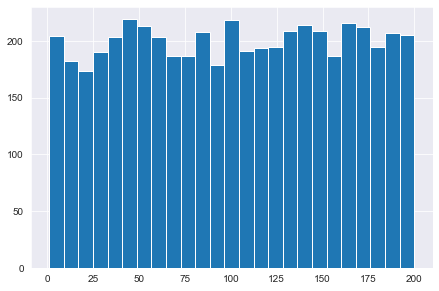

In [9]:
churn_df['duration'].hist(bins=25)

### note from post author:
Survival models have certain requirements:
* A Censor (Customers who haven't churned yet)
* Duration (time t of the customer's activity - account length)
* Event (binary target - churned or not churned)

## Survival

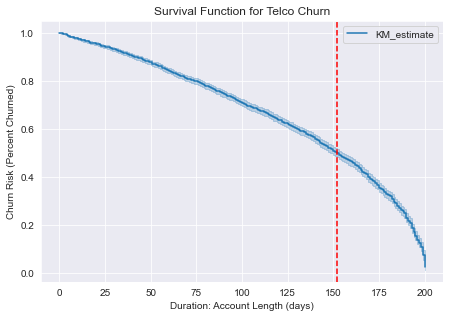

In [11]:
# estimating the survival function (time in days until attrition)

# Kaplan Meier Estimator is a non-parametric statistic used to estimate the survival function from lifetime data 

kmf = KaplanMeierFitter()

kmf.fit(churn_df['duration'], event_observed=churn_df['event'])

kmf.plot_survival_function()
_=plt.title('Survival Function for Telco Churn');
_=plt.xlabel("Duration: Account Length (days)")
_=plt.ylabel("Churn Risk (Percent Churned)")
_=plt.axvline(x=kmf.median_survival_time_, color='r', linestyle='--')


In [ ]:
# median survival time is the point by which half the customers have churned.
# above gives OVERALL baseline for when intervention is needed 
# for each individual, we will use Cox's proportional hazard regression analysis 
# the hazard function is conditioned on rate of a customers remaining until time t or later (risk of churn over time)


## Risk of Churn over time (CPH)

In [12]:
SEED=23
df_train, df_test = train_test_split(churn_df , test_size=0.20, random_state=SEED)

numerical_idx = (
        df_train.select_dtypes(exclude=["object", "category"])
        .drop(['event','duration'],1)
        .columns.tolist()
    )

categorical_idx = df_train.select_dtypes(exclude=["float", "int"]).columns.tolist()

numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("onehot", OneHotEncoder(sparse=False, handle_unknown="ignore")),
        ]
    )

preprocessor = ColumnTransformer(
        [
            ("numerical", numeric_transformer, numerical_idx),
            ("categorical", categorical_transformer, categorical_idx),
        ],
        remainder="passthrough",
    )

train_features = preprocessor.fit_transform(df_train.drop(['event','duration'],1))
test_features = preprocessor.transform(df_test.drop(['event','duration'],1))

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


In [13]:
# note from author: for vanilla XGBoost, we will convert the target into positive for events and negative for non-events and use event duration

In [14]:
# negative values are considered right censored

def survival_y_cox(dframe:pd.DataFrame) -> np.array:
    """Returns array of outcome encoded for XGB"""
    y_survival = []

    for idx, row in dframe[["duration", "event"]].iterrows():
        if row["event"]:
            # uncensored
            y_survival.append(int(row["duration"]))
        else:
            # right censored
            y_survival.append(-int(row["duration"]))
    return np.array(y_survival)

feature_names = np.hstack((np.array(numerical_idx),
                           preprocessor.transformers_[1][1]['onehot'].get_feature_names()))
# personally I don't enjoy this DMatrix approach but will follow along with the author
dm_train = xgb.DMatrix(
    train_features, label=survival_y_cox(df_train), feature_names=feature_names
)

dm_test = xgb.DMatrix(
    test_features, label=survival_y_cox(df_test), feature_names=feature_names
)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [15]:
# Hazard function provides RISK (when is churn most likely to happen)
# Survival Function S(t) returns probability of churn beyond a point of time S(t) = P(T>t), Hazard function h(t) gives an approximate probability that the customer stays up to the time t

In [35]:
# Gradient boosting with objective : maximize log partial likelihood function 
# objective - survival: cox

params = {'eta':0.1,'max_depth':6,'objective':'survival:cox','tree_method':'hist','subsample':0.8,'seed':143}
bst = xgb.train(params, dm_train, num_boost_round=400, evals=[(dm_train, 'train'),(dm_test, 'test')],verbose_eval=int(1e1), early_stopping_rounds=20)
                

[0]	train-cox-nloglik:7.22680	test-cox-nloglik:5.84240
[10]	train-cox-nloglik:6.85317	test-cox-nloglik:5.57941
[20]	train-cox-nloglik:6.72631	test-cox-nloglik:5.50371
[30]	train-cox-nloglik:6.65591	test-cox-nloglik:5.47956
[40]	train-cox-nloglik:6.59812	test-cox-nloglik:5.47841
[50]	train-cox-nloglik:6.54148	test-cox-nloglik:5.48867
[55]	train-cox-nloglik:6.51635	test-cox-nloglik:5.49272


In [32]:
# prediction for this model are returned on the hazard ratio scale

In [36]:
%%capture 

df_test.loc[:,"preds"] = bst.predict(dm_test, output_margin=True) 
df_test.loc[:, "preds_exp"] = bst.predict(dm_test, output_margin=False) 

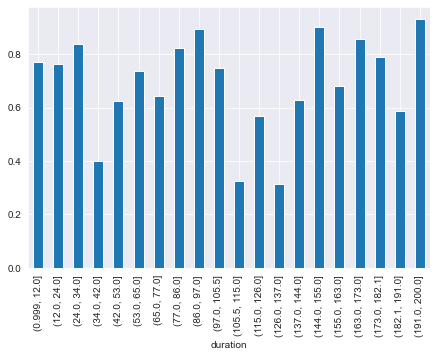

In [37]:
_=df_test.groupby(pd.qcut(df_test['duration'], q=20))['preds_exp'].median().plot(kind="bar")


In [ ]:
# changing the seed value changes these results drastically and every time. 
# model results display large variance

In [ ]:
# the concordance index or C-index is a generalization of the AUC (area under the ROC curve)

In [38]:
_, y_train = get_x_y(df_train,['event','duration'],pos_label=True)
_, y_test = get_x_y(df_test,['event','duration'],pos_label=True)

del _

print("CIC")
print(
    surv_metrics.concordance_index_ipcw(
       y_train,
       y_test,
      df_test['preds'],
        tau=100 # within 100 days
    )
)

print("")
print("Brier Score")

times, score = surv_metrics.brier_score(
y_train,y_test, df_test['preds'], df_test['duration'].max() - 1
)
print(score)

CIC
(0.7280474978540299, 187246, 70953, 0, 1288)

Brier Score
[0.85096896]


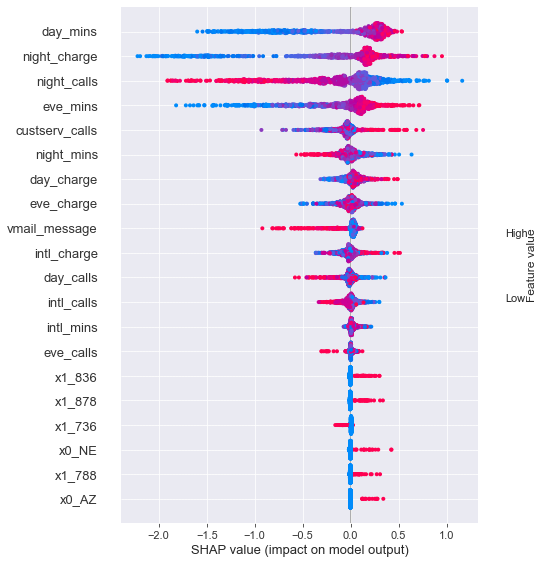

In [39]:
explainer = shap.TreeExplainer(bst, feature_names=feature_names)
shap_values = explainer.shap_values(test_features) 

shap.summary_plot(shap_values, pd.DataFrame(test_features, columns=feature_names))


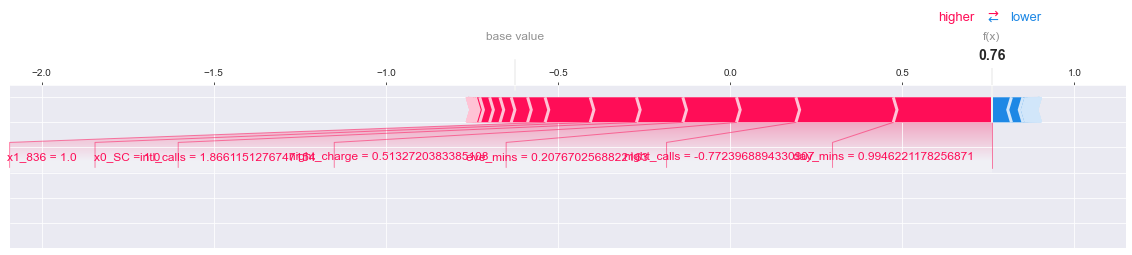

The real label is Churn=True


In [40]:
idx_sample = 128
shap.force_plot(
    explainer.expected_value,
    shap_values[idx_sample, :],
    pd.DataFrame(test_features, columns=feature_names).iloc[idx_sample, :],
    matplotlib=True,
)

print(f"The real label is Churn={y_test[idx_sample][0]}")

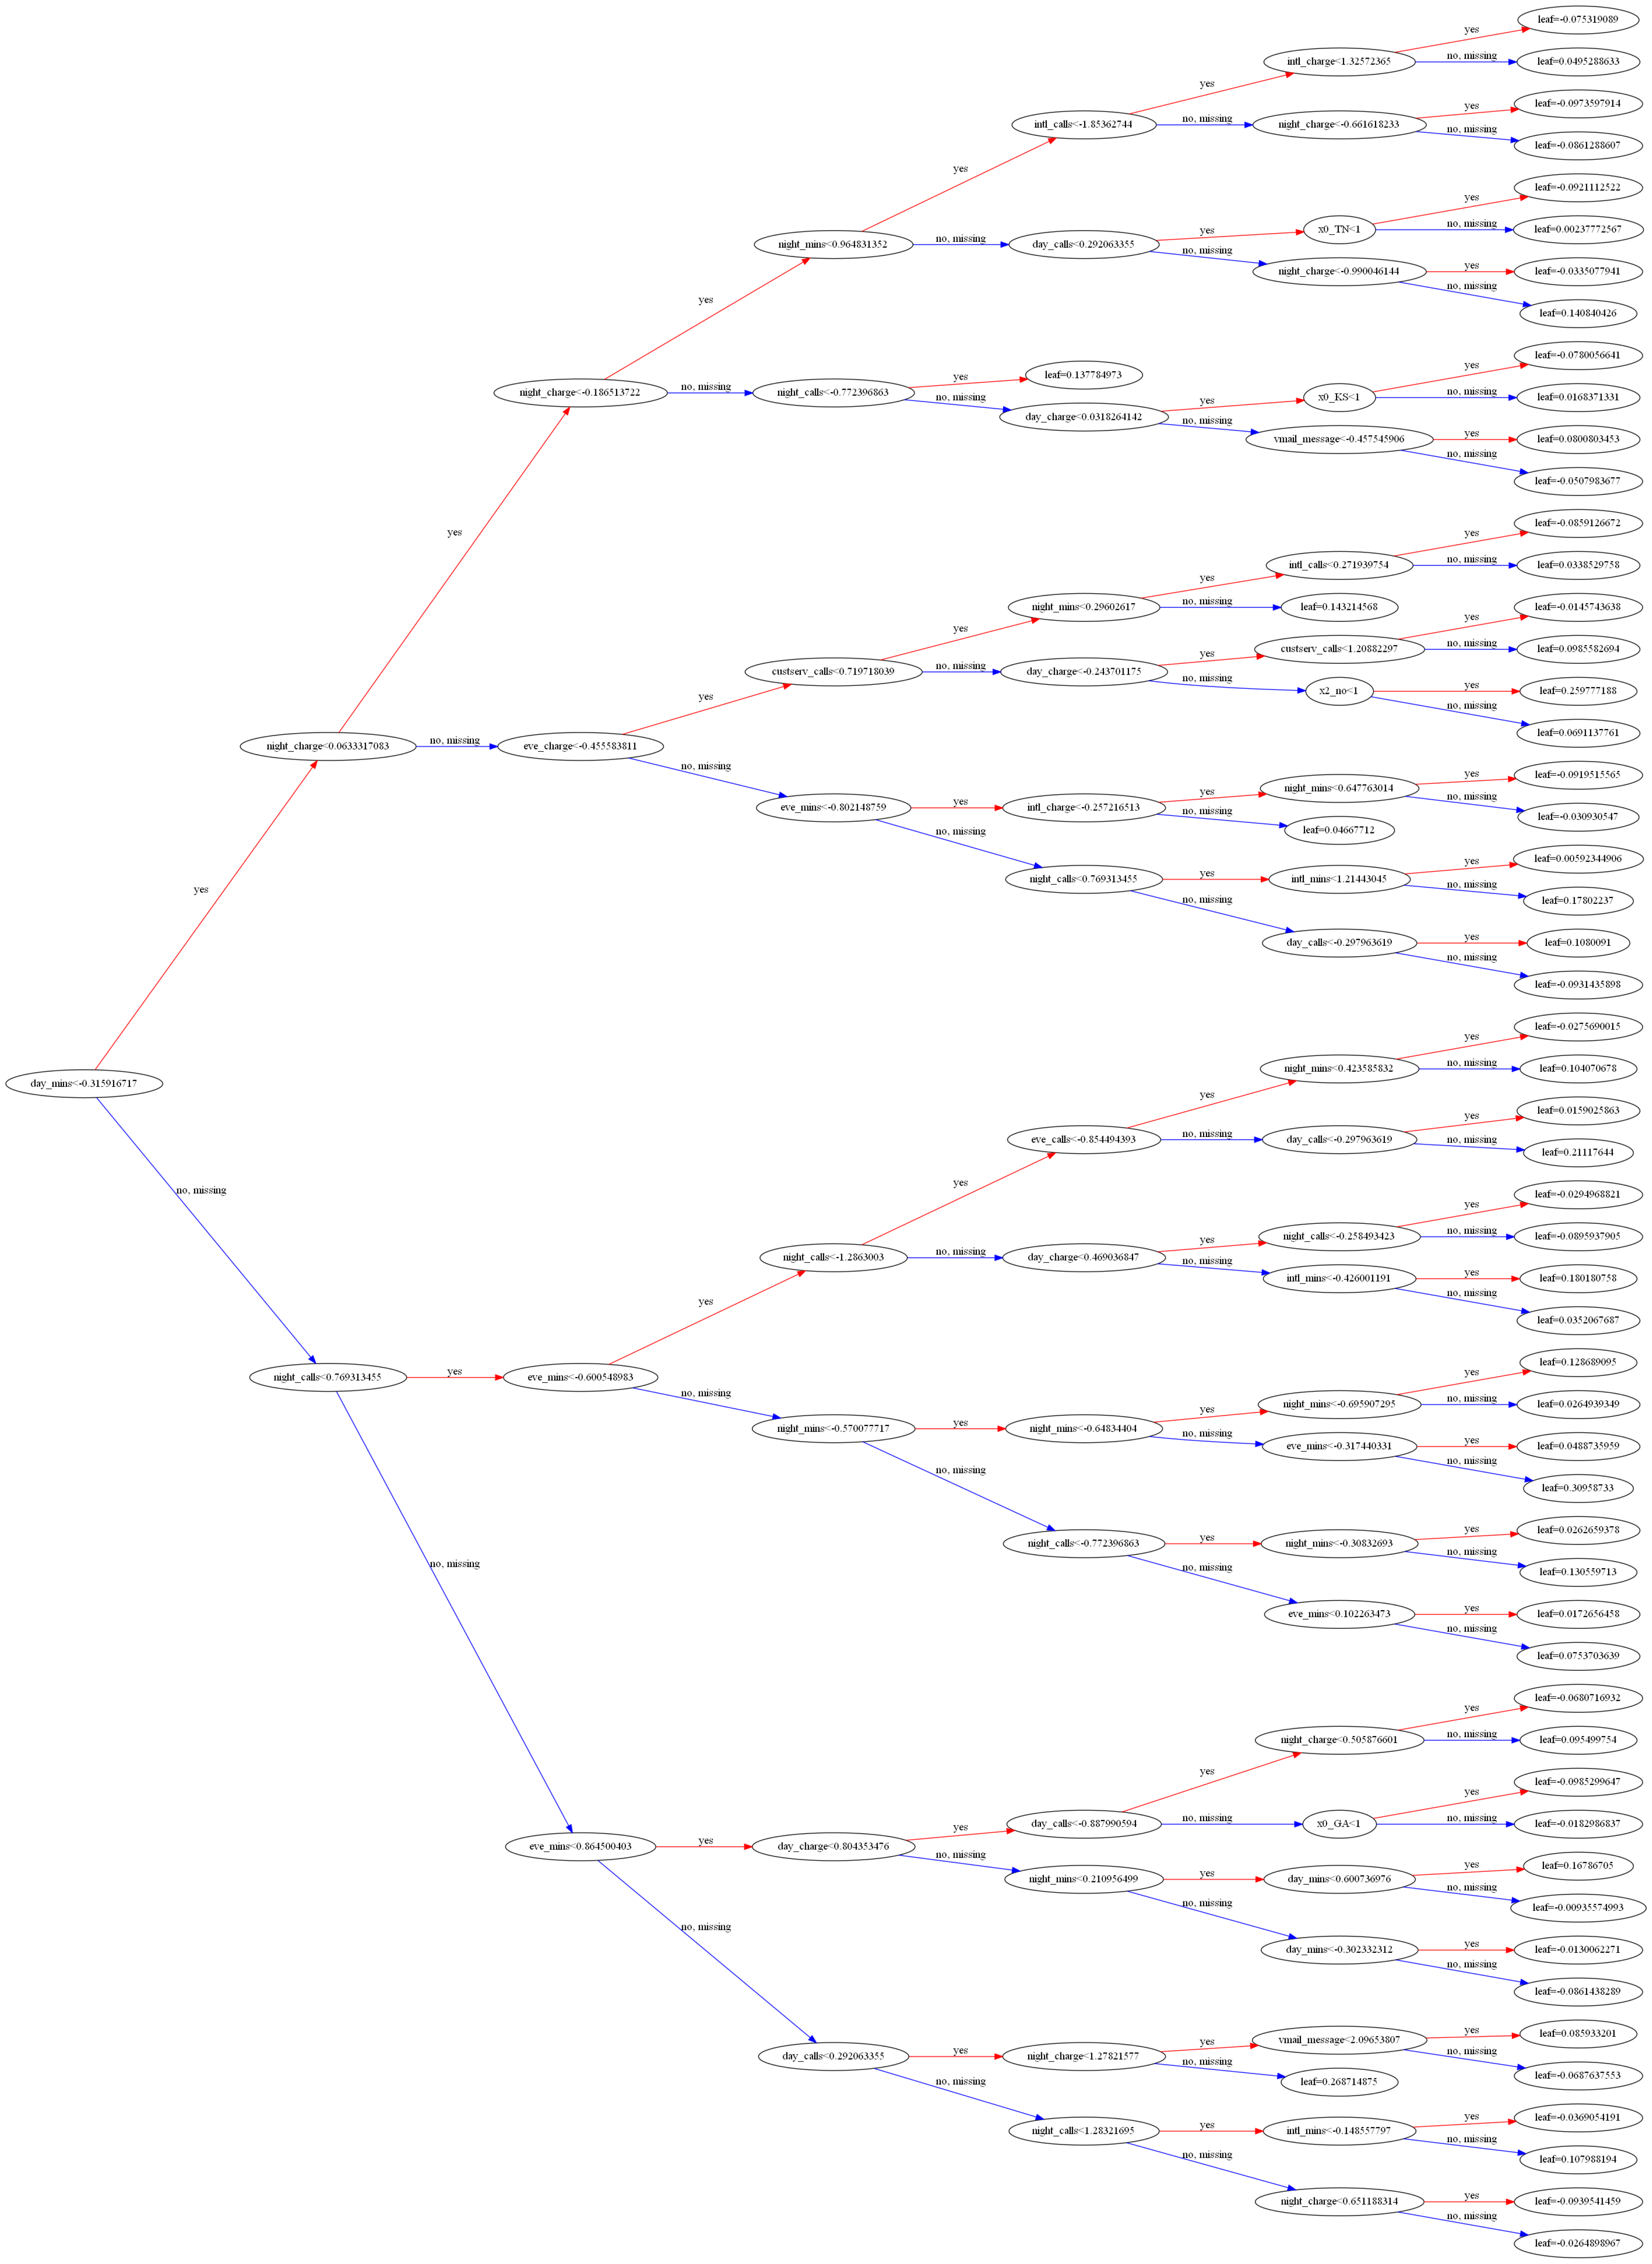

In [41]:
xgb.plot_tree(bst, rankdir="LR", num_trees=0)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig("tree.png", bbox_inches="tight")


In [42]:
from sklearn import metrics

y_preds = df_test.preds.apply(lambda x : np.exp(x))
y_pred = np.where(y_preds > 0.5, 1, 0)

print(f"Accuracy score: {metrics.accuracy_score(df_test.event, y_pred)}")
print(f"Area Under the Curve {metrics.roc_auc_score(df_test.event, y_pred)}")
print("")
print(metrics.classification_report(df_test.event, y_pred))

Accuracy score: 0.926
Area Under the Curve 0.9250801282051282

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       480
           1       0.91      0.95      0.93       520

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [43]:
scores = np.random.normal(size=30).reshape(3,10)
scores_df = pd.DataFrame(scores
                         , index=['Customer A', 'Customer B',' Customer C']
                         , columns=[10,20,30,40,50,60,70,80,90,100])
scores_df

,10,20,30,40,50,60,70,80,90,100
Customer A,-0.4504,1.0726,1.2977,-0.9030,1.3853,-0.3500,0.0103,-0.0979,0.0048,-1.1488
Customer B,0.7639,1.0032,0.4390,1.1573,1.1358,0.6516,-0.1375,-0.2925,-0.4931,0.7849
Customer C,-1.4305,-1.5269,2.5171,-1.2473,0.2382,0.8679,-0.8072,1.1252,-1.2296,-1.4479
